In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [2]:
mura_Dir = "MURA-v1.1/"
train_imgs_path=pd.read_csv(mura_Dir+'train_image_paths.csv',names=["Train Dataset"])
train_labels=pd.read_csv(mura_Dir+'train_labeled_studies.csv',names=["Train Labeled Studies","label"])
test_imgs_path=pd.read_csv(mura_Dir+'valid_image_paths.csv',names=["Test Dataset"])
test_labels=pd.read_csv(mura_Dir+'valid_labeled_studies.csv',names=["Test Labeled Studies","label"])

In [3]:
train_imgs_path=train_imgs_path.sort_values(by=['Train Dataset'])
train_labels=train_labels.sort_values(by=['Train Labeled Studies'])
test_imgs_path=test_imgs_path.sort_values(by=['Test Dataset'])
test_labels=test_labels.sort_values(by=['Test Labeled Studies'])

In [4]:
test_labels['Body Part']=test_labels['Test Labeled Studies'].apply(lambda x: str(x.split('/')[2])[3:])
test_labels['Study Type']=test_labels['Test Labeled Studies'].apply(lambda x: str(x.split('/')[4])[:6])

In [5]:
train_labels['Body Part']=train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[2])[3:])
train_labels['Study Type']=train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[4])[:6])

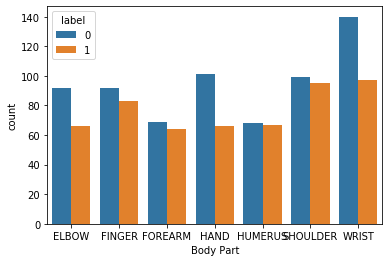

In [6]:
import seaborn as sns
sns.countplot(data=test_labels,x='Body Part',hue='label')

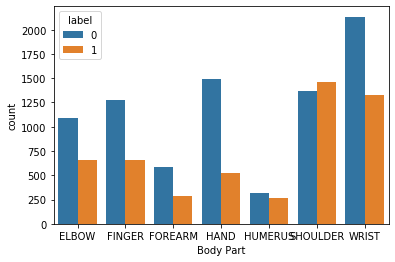

In [7]:
sns.countplot(data=train_labels,x='Body Part',hue='label')

In [8]:
import glob
import cv2
import os 

In [9]:
def fileImagesOfStudy(path):
    img_dir = path # Enter Directory of all images 
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    data = []
    i=0
    for f1 in files:
        i=i+1
        img = cv2.imread(f1)
        data.append(img)
           
    return data

In [10]:
import matplotlib.pyplot as plt


In [12]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [13]:
def stretching_Data(files_,dim):
    stretch=[]
    for e in range(0,len(files_)):
        f=files_.iloc[e][0]
        dd=fileImagesOfStudy(f)
        for n in range(0,len(dd)):
            stretch.append(cv2.resize(dd[n],dsize=dim))
               
    return stretch

In [14]:
def stretching_Labels(labels_):
    labels=[]
    for e in range(0,len(labels_)):
        l=labels_.iloc[e]['label']
        f=labels_.iloc[e][0]
        dd=fileImagesOfStudy(f)
        for n in range(0,len(dd)):
            labels.append(l)
    return labels

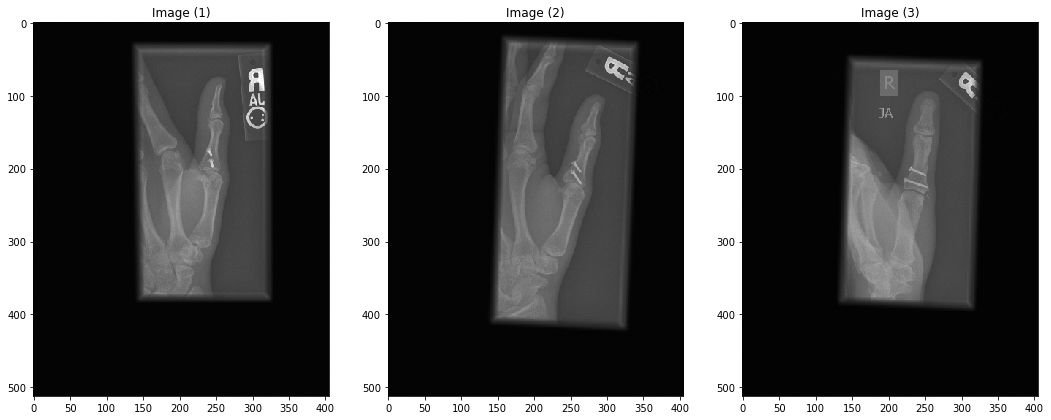

In [15]:
l=train_labels.iloc[2000]['Train Labeled Studies']
images=fileImagesOfStudy(l)
show_images(images)

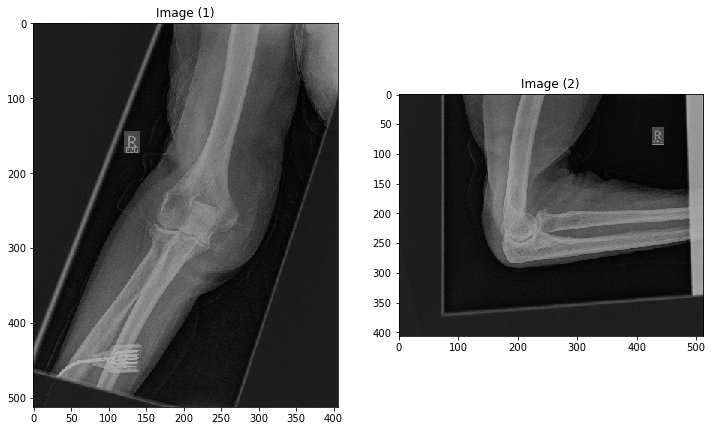

In [16]:
l=train_labels.iloc[3]['Train Labeled Studies']
images=fileImagesOfStudy(l)
show_images(images)

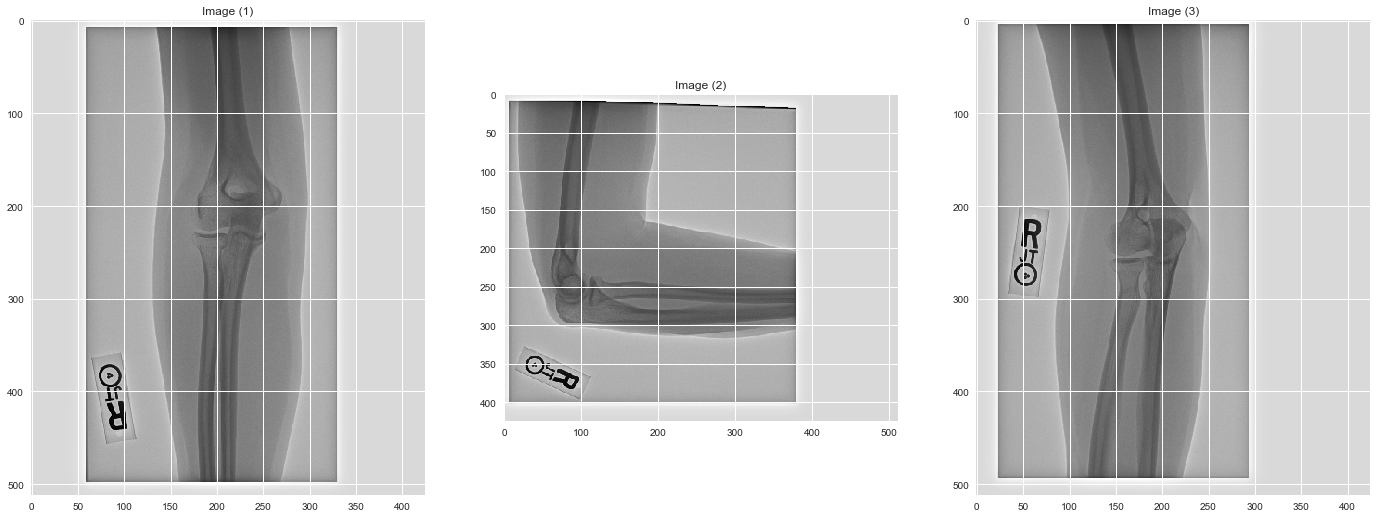

In [61]:
l=test_labels.iloc[3]['Test Labeled Studies']
images=fileImagesOfStudy(l)
show_images(images)

In [19]:
##Classes
train_labels_ELbow = train_labels[train_labels['Body Part'] =='ELBOW']
train_labels_FINGER = train_labels[train_labels['Body Part'] =='FINGER']
train_labels_FOREARM = train_labels[train_labels['Body Part'] =='FOREARM']
train_labels_Hand = train_labels[train_labels['Body Part'] =='HAND']
train_labels_HUMERUS = train_labels[train_labels['Body Part'] =='HUMERUS']
train_labels_SHOULDER = train_labels[train_labels['Body Part'] =='SHOULDER']
train_labels_WRIST = train_labels[train_labels['Body Part'] =='WRIST']



1754
1935
877
2018
592
2821
3460


In [21]:
test_labels_ELbow = test_labels[test_labels['Body Part'] =='ELBOW']


In [22]:
vggDim=(90,90)


In [23]:
train_labels['Body Part'].unique()

array(['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER',
       'WRIST'], dtype=object)

In [24]:
stretchData_VGG_Elbow_Test=stretching_Data(test_labels_ELbow,vggDim)
elbowLabels_Test=stretching_Labels(test_labels_ELbow)

In [25]:
elbowLabels=stretching_Labels(train_labels_ELbow)

In [26]:
stretchData_VGG_Elbow_Train=stretching_Data(train_labels_ELbow,vggDim)


In [28]:
stretchData_VGG_Elbow=np.asarray(stretchData_VGG_Elbow_Train)
elbowLabels=np.asarray(elbowLabels)
stretchData_VGG_Elbow_Test=np.asarray(stretchData_VGG_Elbow_Test)
elbowLabels_Test=np.asarray(elbowLabels_Test)


In [29]:
stretchData_VGG_Elbow.shape

(4931, 90, 90, 3)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
%matplotlib inline
plt.style.use("seaborn")

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers
from keras import applications
from keras import backend as K


Using TensorFlow backend.


In [31]:
vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=stretchData_VGG_Elbow.shape[1:])

In [42]:
vgg19_model = Sequential()
vgg19_model.add(vgg19)
vgg19_model.add(Flatten())
vgg19_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
vgg19_model.add(Dropout(0.5))
vgg19_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
vgg19_model.add(Dropout(0.5))
vgg19_model.add(Dense(1, activation='sigmoid'))
vgg19_model.layers[0].trainable = False

In [45]:
vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_vgg19 = vgg19_model.fit(stretchData_VGG_Elbow, elbowLabels, epochs=5, batch_size=100, validation_data=(stretchData_VGG_Elbow_Test, elbowLabels_Test))

Train on 4931 samples, validate on 465 samples
Epoch 1/5
4931/4931 [==============================] - 439s 89ms/step - loss: 2.5249 - accuracy: 0.6206 - val_loss: 1.8171 - val_accuracy: 0.6860
Epoch 2/5
4931/4931 [==============================] - 451s 91ms/step - loss: 1.6744 - accuracy: 0.6621 - val_loss: 1.4853 - val_accuracy: 0.6667
Epoch 3/5
4931/4931 [==============================] - 385s 78ms/step - loss: 1.3620 - accuracy: 0.6709 - val_loss: 1.2319 - val_accuracy: 0.7011
Epoch 4/5
4931/4931 [==============================] - 437s 89ms/step - loss: 1.1521 - accuracy: 0.7088 - val_loss: 1.1113 - val_accuracy: 0.6968
Epoch 5/5
4931/4931 [==============================] - 455s 92ms/step - loss: 1.0339 - accuracy: 0.7108 - val_loss: 1.0012 - val_accuracy: 0.7161


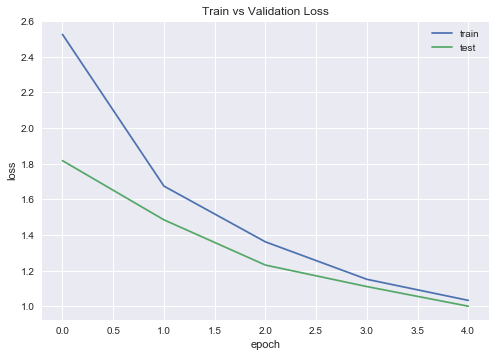

In [46]:
plt.plot(history_vgg19.history['loss'])
plt.plot(history_vgg19.history['val_loss'])
plt.title("Train vs Validation Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [47]:
test_loss, test_acc = vgg19_model.evaluate(stretchData_VGG_Elbow_Test, elbowLabels_Test, batch_size=100)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_acc)


465/465 [==============================] - 37s 79ms/step
Loss on test set:  1.0012040054926308
Accuracy on test set:  0.7161290049552917


In [49]:
test_logits = vgg19_model.predict(stretchData_VGG_Elbow_Test, batch_size=10)


In [57]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


<Figure size 576x396 with 0 Axes>

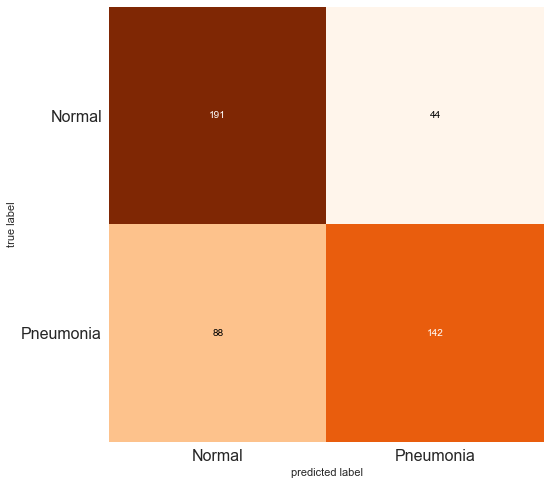

In [58]:
cm  = confusion_matrix(elbowLabels_Test, np.round(test_logits))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [59]:
true_negative, false_positive, false_negative, true_positive  = cm.ravel()
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precison of MURA for pneumonia:{:.2f}'.format(precision))
print('Recall of MURA for pneumonia:{:.2f}'.format(recall))


Precison of MURA for pneumonia:0.76
Recall of MURA for pneumonia:0.62
